In [15]:
import sys
sys.path.append('../src/training-on-CM2.6')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
import cmocean

from helpers.cm26 import DatasetCM26, read_datasets
from helpers.selectors import *
from helpers.plot_helpers import *

%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plot snapshot of predictions

## Read testing dataset 

In [39]:
true_data = read_datasets(['test'], factors=[4,9], subfilter='subfilter-large')

Reading from folder /vast/pp2681/CM26_datasets/ocean3d/subfilter-large/FGR3/factor-4
Reading from folder /vast/pp2681/CM26_datasets/ocean3d/subfilter-large/FGR3/factor-9


## Read from the disk ANN skill on testing dataset

In [17]:
def read_skill(exp='subfilter/FGR3/EXP1', factors=[4,9,12,15], base_path='/scratch/pp2681/mom6/CM26_ML_models/ocean3d/'):
    ds = {}
    for factor in factors:
        data = xr.open_dataset(f'{base_path}/{exp}/skill-test/factor-{factor}.nc', chunks={'zl':1})
        data['zl'] = -data['zl']
        ds[factor] = data
        
    return ds

In [18]:
# Default ANN tested in online simulations
ann_default = read_skill('subfilter/FGR3/EXP1')

In [20]:
data = {}
# Both ANNs are trained on coarsegraining factor 9 and upper fluid layer (i.e., depth index is 0)
# The first ANN uses dimensional scaling, the second does not
for key in ['factor-9-depth-0', 'no-scaling-factor-9-depth-0']:
    data[key] = read_skill(f'subfilter-large/FGR3/dimensional-scaling/20/{key}');

## Function plotting snapshot of subfilter kinetic energy

In [99]:
def plot_SGS_KE(array, param, ax=None, vmin=0., vmax=0.05, text=None):
    if ax is None:
        ax = plt.subplot(1,1,1,projection = ccrs.Orthographic(central_latitude=5, central_longitude=-70))

    # Use red part of balance colorbar
    cmap = cmocean.tools.crop_by_percent(cmocean.cm.balance, 50, which='min')
    cmap.set_bad('gray')

    im = ax.pcolormesh(param.geolon_u, param.geolat_u, array, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), rasterized=True)
    ax.coastlines(rasterized=True);

    if text is not None:
        ax.text(-71,-17, text, transform=ccrs.Geodetic(), color='white', fontsize=9)
    return im

In [115]:
# Read grid information
param_4 = true_data['test-4'].param
param_9 = true_data['test-9'].param
# Define NaN masks
mask_4 = xr.where(param_4.wet<0.5, np.nan, 1).drop_vars('zl').isel(zl=0)
mask_9 = xr.where(param_9.wet<0.5, np.nan, 1).drop_vars('zl').isel(zl=0)

# Compute subfilter KE from momentum fluxes
SGS_KE = lambda dataset: -0.5 * (dataset.Txx_pred + dataset.Tyy_pred).isel(zl=0).compute()
SGS_KE_target = lambda dataset: -0.5 * (dataset.Txx + dataset.Tyy).isel(zl=0).compute()

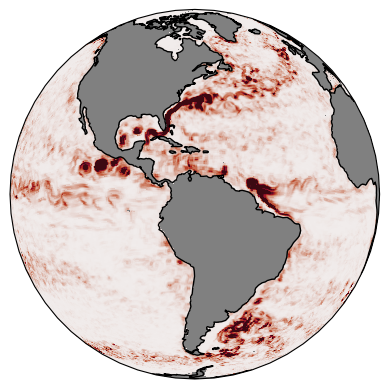

In [101]:
# Check plotting function on one snapshot of diagnosed data
plot_SGS_KE(SGS_KE_target(ann_default[4]) * mask_4, param_4)

## Precompute R2 and correlation scores

In [146]:
def M2(x,y=None,centered=False,dims=None,exclude_dims='zl', mask=None):
    '''
    This function allows to compute second moment and can be used for computation
    of R2 and correlation scores
    '''
    if dims is None and exclude_dims is not None:
        dims = []
        for dim in x.dims:
            if dim not in exclude_dims:
                dims.append(dim)

    if mask is not None:
        x = x * mask
        if y is not None:
            y = y * mask

    if y is None:
        y = x
    if centered:
        return (x*y).mean(dims) - x.mean(dims)*y.mean(dims)
    else:
        return (x*y).mean(dims)

In [150]:
def snapshot_skill(target, prediction, mask):
    R2 = float(1 - M2(target-prediction, mask=mask) / M2(target, mask=mask))
    correlation = float(M2(target,prediction,centered=True) / np.sqrt(M2(target,centered=True) * M2(prediction,centered=True)))

    return round(R2,2), round(correlation,2)

In [154]:
print(snapshot_skill(SGS_KE_target(data['factor-9-depth-0'][9]), SGS_KE(data['factor-9-depth-0'][9]), mask_9))
print(snapshot_skill(SGS_KE_target(data['factor-9-depth-0'][9]), SGS_KE(data['no-scaling-factor-9-depth-0'][9]), mask_9))

print(snapshot_skill(SGS_KE_target(data['factor-9-depth-0'][4]), SGS_KE(data['factor-9-depth-0'][4]), mask_4))
print(snapshot_skill(SGS_KE_target(data['factor-9-depth-0'][4]), SGS_KE(data['no-scaling-factor-9-depth-0'][4]), mask_4))

(0.83, 0.91)
(0.65, 0.85)
(0.86, 0.93)
(-4.93, 0.77)


## Plot multiple snapshots

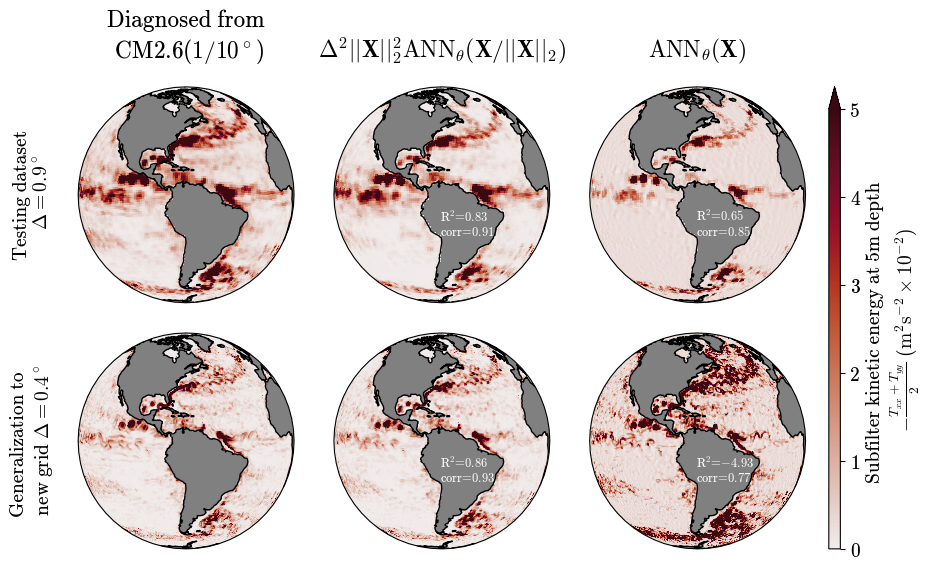

In [171]:
default_rcParams({'figure.subplot.wspace': 0.0, 'figure.subplot.hspace': 0.14, 'font.size':14})

fig, axes = plt.subplots(
    nrows=2, ncols=3,
    figsize=(12, 6),
    subplot_kw={'projection':ccrs.Orthographic(central_latitude=5, central_longitude=-70)}
)
axes = axes.flatten()


plot_SGS_KE(SGS_KE_target(data['factor-9-depth-0'][9])*mask_9, param_9,ax=axes[0])
axes[0].set_title('Diagnosed from\n CM2.6($1/10^\circ$)', y=1.1)

plot_SGS_KE(SGS_KE(data['factor-9-depth-0'][9])*mask_9, param_9,ax=axes[1], text='R$^2$=$0.83$\ncorr=$0.91$')
axes[1].set_title('$\\Delta^2 ||\\mathbf{X}||_2^2 \\mathrm{ANN}_{\\theta} (\\mathbf{X} / ||\\mathbf{X}||_2)$', y=1.1)

plot_SGS_KE(SGS_KE(data['no-scaling-factor-9-depth-0'][9])*mask_9, param_9,ax=axes[2], text='R$^2$=$0.65$\ncorr=$0.85$')
axes[2].set_title('$\\mathrm{ANN}_{\\theta} (\\mathbf{X})$', y=1.1)


plot_SGS_KE(SGS_KE_target(data['factor-9-depth-0'][4])*mask_4, param_4,ax=axes[3])

plot_SGS_KE(SGS_KE(data['factor-9-depth-0'][4])*mask_4, param_4,ax=axes[4], text='R$^2$=$0.86$\ncorr=$0.93$')

im_SGS_KE = plot_SGS_KE(SGS_KE(data['no-scaling-factor-9-depth-0'][4])*mask_4, param_4,ax=axes[5], text='R$^2$=$-4.93$\ncorr=$0.77$')

cbar = plt.colorbar(im_SGS_KE, ax=plt.gcf().axes, shrink=1, extend='max', pad=0.025, aspect=40, 
             label='Subfilter kinetic energy at 5m depth \n$-\\frac{T_{xx} + T_{yy}}{2}$ ($\mathrm{m}^2\mathrm{s}^{-2}\\times 10^{-2}$)')
cbar.set_ticks(np.arange(6) * 1e-2)
cbar.set_ticklabels(np.arange(6))

fig.text(0.12,0.6, 'Testing dataset\n $\\Delta=0.9^\circ$', color='k', rotation=90, ha='center')
fig.text(0.12,0.17, 'Generalization to \n new grid $\\Delta=0.4^\circ$', color='k', rotation=90, ha='center')
plt.savefig('figures/SGS-KE-snapshot.pdf', dpi=200)

In [182]:
import cmocean
import matplotlib.patches as patches
def plot_metric(exp=None, metric='R2_away',vmin=-1,vmax=1,cmap=cmocean.cm.balance,err_format="%.2f", show_numbers=True, title=False, xlabel=False, ylabel=False):
    data = xr.concat([exp[factor][metric] for factor in [4,9,12,15]], dim='factor')
    im = data.drop_vars(['zl']).plot(x='factor', y='zl',cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

    if show_numbers:
    # Add text annotations
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                plt.text(i, j, err_format % float(data[i,j]),
                        ha='center', va='center', color='white', fontsize=10)

    rectangle = patches.Rectangle(
                                    (1 - 0.45, 0 - 0.45),  # Lower-left corner of the rectangle
                                    0.9,  # Width (1 cell)
                                    0.9,  # Height (1 cell)
                                    linewidth=2,  # Border thickness
                                    edgecolor='y',  # Border color
                                    facecolor='none',  # No fill color
                                )
    plt.gca().add_patch(rectangle)

    rectangle = patches.Rectangle(
                                    (0 - 0.45, 0 - 0.45),  # Lower-left corner of the rectangle
                                    0.9,  # Width (1 cell)
                                    0.9,  # Height (1 cell)
                                    linewidth=2,  # Border thickness
                                    edgecolor='tab:orange',  # Border color
                                    facecolor='none',  # No fill color
                                )
    plt.gca().add_patch(rectangle)
    
    
    if ylabel:
        plt.yticks(np.arange(10),[5, 55, 110, 180,330, 730,1500,2500,3500,4500]);
        plt.ylabel('Depth [m]')
    else:
        plt.yticks(np.arange(10),['']*10);
        plt.ylabel('')
    
    if xlabel:
        plt.xticks(np.arange(4),['$0.4^\circ$','$0.9^\circ$','$1.2^\circ$','$1.5^\circ$']);
        plt.xlabel('Coarse-grid spacing, $\Delta$')
    else:
        plt.xticks(np.arange(4), ['']*4)
        plt.xlabel('')
        
    if metric == 'R2':
        title_str = '$R^2$'
    elif metric == 'corr':
        title_str = 'Correlation'
    elif metric == 'opt_scaling':
        title_str = 'Optimal scaling'
    
    mean_val = float(data.mean())
    min_val = float(data.min())
    max_val = float(data.max())
    
    if title:
        plt.title(metric+f' = ${err_format}$ $({err_format}-{err_format})$' % (mean_val,min_val,max_val), fontsize=12)
    else:
        plt.title('')
    
    plt.gca().invert_yaxis()
    return im

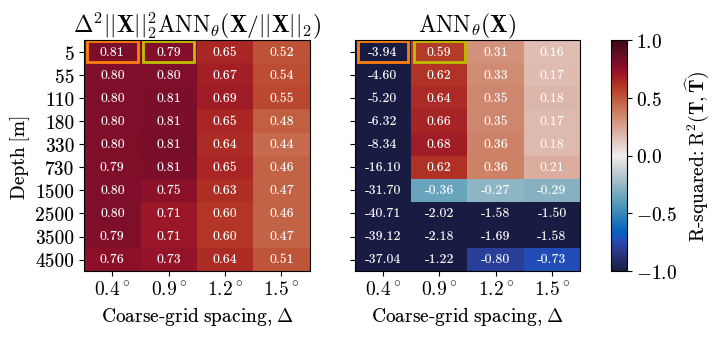

In [183]:
default_rcParams({'figure.subplot.wspace': 0.2, 'figure.subplot.hspace': 0.2, 'font.size':14})
fig = plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plot_metric(data['factor-9-depth-0'], 'R2T', ylabel=True, xlabel=True);
plt.title('$\\Delta^2 ||\\mathbf{X}||_2^2 \\mathrm{ANN}_{\\theta} (\\mathbf{X} / ||\\mathbf{X}||_2)$')
plt.subplot(1,2,2)
im_R2 = plot_metric(data['no-scaling-factor-9-depth-0'], 'R2T', xlabel=True);
plt.title('$\\mathrm{ANN}_{\\theta} (\\mathbf{X})$')

axes = plt.gcf().axes
plt.colorbar(im_R2, ax=axes[0:2], label='R-squared: $\mathrm{R}^2(\\mathbf{T},\\widehat{\\mathbf{T}})$', aspect=15)

plt.savefig('figures/offline-metrics-T.pdf', dpi=200)

# Schematic of input/output features

In [270]:
ds = read_datasets(['validate'], [4], subfilter='subfilter-large')['validate-4']

Reading from folder /vast/pp2681/CM26_datasets/ocean3d/subfilter-large/FGR3/factor-4


In [271]:
ds2d = ds.select2d(time=0,zl=0)

In [272]:
def select_plot(array, time=None):
    return select_LatLon(array, Lat=(25, 35), Lon=(-85,-75), time=time)

In [273]:
sh_xy = select_plot(ds2d.nanvar(ds2d.data.sh_xy_h)).compute()

In [274]:
sh_xx = select_plot(ds2d.nanvar(ds2d.data.sh_xx)).compute()

In [275]:
vort_xy = select_plot(ds2d.nanvar(ds2d.data.rel_vort_h)).compute()

In [276]:
Txx = select_plot(ds2d.nanvar(ds2d.data.Txx)).compute()

In [277]:
Txy = select_plot(ds2d.nanvar(ds2d.data.Txy)).compute()

In [278]:
Tyy = select_plot(ds2d.nanvar(ds2d.data.Tyy)).compute()

In [279]:
import cartopy.crs as ccrs

def plot_strain(array, zl=0, cmap=cmocean.cm.balance, vmin=-2e-5, vmax=2e-5):
    
    ax = plt.subplot(1,1,1,projection = ccrs.PlateCarree())
    ax.coastlines(rasterized=True);
    cmap.set_bad('gray')

    array.plot.pcolormesh(cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), rasterized=True, add_colorbar=False)
    plt.title('')
    plt.gca().set_aspect(1)

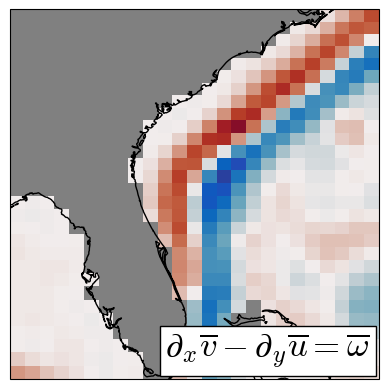

In [303]:
default_rcParams({})
plot_strain(vort_xy)
t = plt.gcf().text(0.467,0.155,'$\partial_x \overline{v} - \partial_y \overline{u}=\\overline{\omega}$', fontsize=25, color='black')
t.set_bbox(dict(facecolor='white', edgecolor='black'))
plt.savefig('figures/vort_xy.pdf', dpi=100)

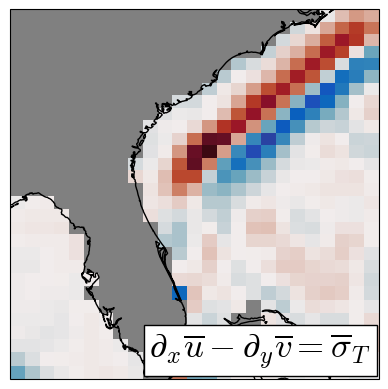

In [304]:
plot_strain(sh_xx)
t = plt.gcf().text(0.442,0.155,'$\partial_x \overline{u} - \partial_y \overline{v}=\\overline{\sigma}_{T}$', fontsize=25, color='black')
t.set_bbox(dict(facecolor='white', edgecolor='black'))
plt.savefig('figures/sh_xx.pdf', dpi=100)

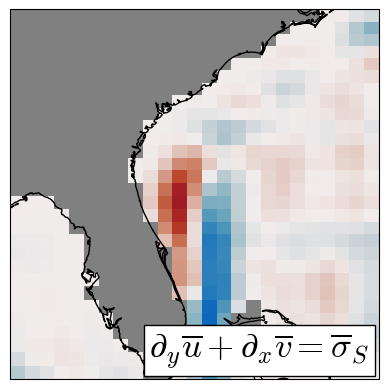

In [305]:
plot_strain(sh_xy)
t = plt.gcf().text(0.442,0.155,'$\partial_y \overline{u} + \partial_x \overline{v}=\\overline{\sigma}_{S}$', fontsize=25, color='black')
t.set_bbox(dict(facecolor='white', edgecolor='black'))
plt.savefig('figures/sh_xy.pdf', dpi=100)

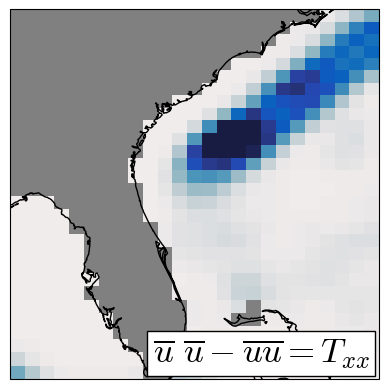

In [344]:
plot_strain(Txx, vmin=-0.25,vmax=0.25)
t = plt.gcf().text(0.447,0.145,'$\\overline{u} \, \, \\overline{u} - \\overline{uu}=T_{xx}$', fontsize=25, color='black')
t.set_bbox(dict(facecolor='white', edgecolor='black'))
plt.savefig('figures/Txx.pdf', dpi=100)

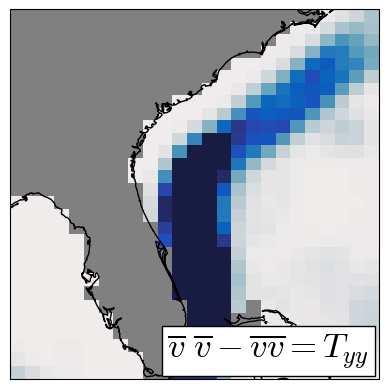

In [331]:
plot_strain(Tyy, vmin=-0.25,vmax=0.25)
t = plt.gcf().text(0.47,0.155,'$\\overline{v} \, \, \\overline{v} - \\overline{vv}=T_{yy}$', fontsize=25, color='black')
t.set_bbox(dict(facecolor='white', edgecolor='black'))
plt.savefig('figures/Tyy.pdf', dpi=100)

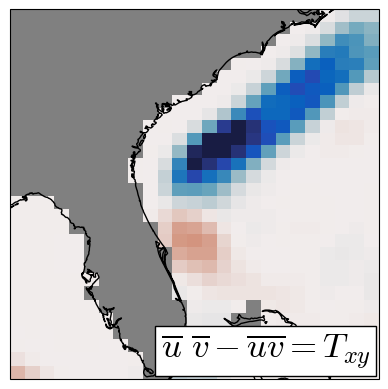

In [334]:
plot_strain(Txy, vmin=-0.25,vmax=0.25)
t = plt.gcf().text(0.46,0.155,'$\\overline{u} \, \, \\overline{v} - \\overline{uv}=T_{xy}$', fontsize=25, color='black')
t.set_bbox(dict(facecolor='white', edgecolor='black'))
plt.savefig('figures/Txy.pdf', dpi=100)